# Régression & optimisation par descente de gradient

Ce tme a deux objectifs: 
 - acquérir les connaissances de base pour faire face au problème de la régression, c'est à dire de l'estimation d'un score réel correpondant à une situation,
 - travailler sur les techniques d'optimisation par descente de gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Génération de données jouet & construction d'une solution analytique

Dans un premier temps, générons des données jouets paramétriques:
 - $N$: nombre de points à générer
 - $x \in [0, 1]$ tirage avec un simple rand() ou un linspace() -au choix-
     - Si vous optez pour un tirage aléatoire des abscisses, triez les points pour simplifier les traitements ultérieurs
 - $y=ax+b+\epsilon, \epsilon \sim \mathcal N(0,\sigma^2)$
     - Rappel : en multipliant un tirage aléatoire selon une gaussienne centrée réduite par $\sigma$ on obtient le bruit décrit ci-dessus

Afin de travailler sur les bonnes pratiques, nous distinguerons un ensemble d'apprentissage et un ensemble de test.
Les deux sont tirés selon la même distribution. L'ensemble de test comptera -arbitrairement- 1000 points.

In [2]:
def gen_data_lin(a, b, sig, N=500, Ntest=1000):
    # On génère X et epsilon; après on calcule y à partir de ces valeurs
    X_train, X_test = np.sort(np.random.rand(N)), np.sort(np.random.rand(Ntest))
    eps_train, eps_test = np.random.randn(N) * sig, np.random.randn(Ntest) * sig
    y_train, y_test = a * X_train + b + eps_train, a * X_test + b + eps_test
    return X_train, y_train, X_test, y_test


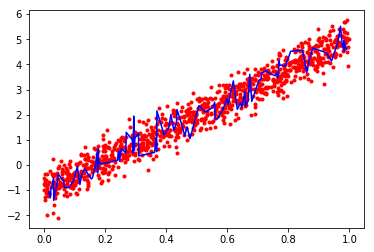

In [3]:
# génération de données jouets:
a = 6.
b = -1.
N = 100
sig = .4 # écart type

X_train, y_train, X_test, y_test = gen_data_lin(a, b, sig, N)

plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')
plt.show()

Vous devez obtenir quelque chose de la forme:
![données jouet](fig/gen_data.png)

## Validation des formules analytiques
Nous avons vu deux types de résolutions analytique: à partir des estimateurs des espérances et co-variances d'une part et des moindres carrés d'autre part. Testons les deux méthodes.

### Estimation de paramètres probabilistes
 - $\hat a = \frac{\mbox{cov}(X,Y)}{\sigma_x^2}$
 - $\hat b = E(Y)−\frac{\mbox{cov}(X,Y)}{\sigma_x^2} E(X)$
 
 Estimer les paramètres, calculer l'erreur au sens des moindres carrés sur les données d'apprentissage et de test, puis tracer la droite de régression

In [4]:
def modele_lin_analytique(X_train, y_train):
    # À partir de données on estime espérance juste comme la moyenne de l'échantillon
    # En utilisant ce règle d'estimation on calcule une co-variance entre X et Y et une variance de X
    cov_XY = np.mean((X_train - X_train.mean()) * (y_train - y_train.mean()))
    var_X = X_train.std() ** 2
    # Après, on calcule les paramètres par les formules données ci-dessus
    ahat = cov_XY / var_X
    bhat = y_train.mean() - ahat * X_train.mean()
    return ahat, bhat

ahat, bhat = modele_lin_analytique(X_train, y_train)
print(ahat, bhat)
# On voit qu'on s'approche vers le point (6, -1) qui est solution optimale assez précisement

6.06184145508388 -1.0730760251763203


In [5]:
def erreur_mc(y, yhat):
    return ((y-yhat)**2).mean()

yhat_train = ahat*X_train+bhat
yhat_test  = ahat*X_test+bhat

print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_train, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_test, y_test))

Erreur moyenne au sens des moindres carrés (train): 0.15511377683641359
Erreur moyenne au sens des moindres carrés (test): 0.16228085202119552


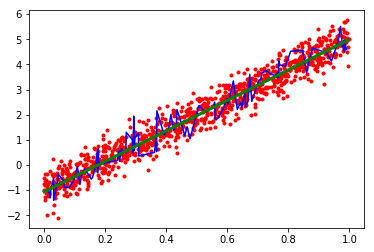

In [6]:
plt.figure()
plt.plot(X_test, y_test, 'r.')
plt.plot(X_train, y_train, 'b')
plt.plot(X_test, yhat_test, 'g', lw=3)
plt.show()

## Formulation au sens des moindres carrés

Nous partons directement sur une écriture matricielle. Du coup, il est nécessaire de construire la matrice enrichie $Xe$:
    $$Xe = \left[\begin{array}{cc}
                X_0 & 1\\
                \vdots & \vdots\\
                X_N & 1
                \end{array}
                \right] $$
Le code de la fonction d'enrichissement est donné ci-dessous.

Il faut ensuite poser et résoudre un système d'équations linéaires de la forme:
$$ A w = B $$
**Rappel des formules vues en cours/TD:**
$$ A=X^T X$$
$$ B=X^T Y$$
Fonction de résolution: `np.linalg.solve(A,B)`
Vous devez obtenir la même solution que précédemment. 

In [7]:
def make_mat_lin_biais(X): # fonctionne pour un vecteur unidimensionel X
    N = len(X)
    return np.hstack((X.reshape(N,1),np.ones((N,1))))

In [8]:
Xe = make_mat_lin_biais(X_train)
# Pour calculer w on n'utilise que les expressions de NumPy pour traitement de matrices et que np.linalg.solve
# pour résoudre le système d'équations linéaires
A = np.dot(Xe.T, Xe)
B = np.dot(Xe.T, y_train)
w = np.linalg.solve(A, B)

# On obtient ici toujours la même résultat que ci-dessus
print(w)

[ 6.06184146 -1.07307603]


Soit les données polynomiales générées avec la fonction ci-dessous
 - proposer & une solution d'enrichissement (vue en cours et TD) 
 - résoudre analytiquement le problème des moindres carrés
 - calculer l'erreur au sens des moindes carrés en apprentissage ET en test
 - tracer les données et la solution

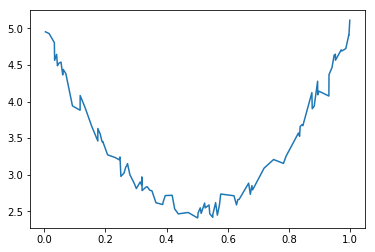

In [9]:
def gen_data_poly2(a, b, c, sig, N=500, Ntest=1000):
    '''
    Tire N points X aléatoirement entre 0 et 1 et génère y = ax^2 + bx + c + eps
    eps ~ N(0, sig^2)
    '''
    X_train = np.sort(np.random.rand(N))
    X_test  = np.sort(np.random.rand(Ntest))
    y_train = a*X_train**2+b*X_train+c+np.random.randn(N)*sig
    y_test  = a*X_test**2 +b*X_test +c+np.random.randn(Ntest)*sig
    return X_train, y_train, X_test, y_test

Xp_train, yp_train, Xp_test, yp_test = gen_data_poly2(10, -10, 5, 0.1, N=100, Ntest=100)
plt.figure()
plt.plot(Xp_train, yp_train)
plt.show()

[ 9.96858911 -9.96166643  4.99775031]
Erreur moyenne au sens des moindres carrés (train): 0.0076166358875563245
Erreur moyenne au sens des moindres carrés (test): 0.011531393885787748


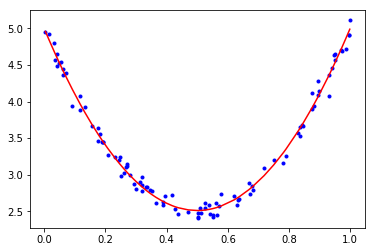

In [10]:
def make_mat_poly_biais(X, deg=2): # fonctionne pour un vecteur unidimensionel X
    # On passe ici le paramètre deg pour degré maximal et on retourne une matrice
    # [X^deg, X^(deg-1), ..., X, np.ones], où X^d est une colonne de matrice
    N = len(X)
    # Pour réaliser cette fonction on n'utilise que les expressions de NumPy
    return np.hstack(tuple(X.reshape(N,1) ** d for d in range(deg, -1, -1)))

# On remplit Xe et Xe_t en utilisant une fonction ci-dessus
Xe   = make_mat_poly_biais(Xp_train)
Xe_t = make_mat_poly_biais(Xp_test)
# On calcule les valeurs des poids
w    = np.linalg.solve(np.dot(Xe.T, Xe), np.dot(Xe.T, yp_train))
print(w)

# On prédit les valeurs de y
yhat   = np.dot(Xe, w)
yhat_t = np.dot(Xe_t, w)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, yp_test))

plt.figure()
plt.plot(Xp_train, yp_train, 'b.')
plt.plot(Xp_train, yhat, 'r')
plt.show()

# Fonction de coût & optimisation par descente de gradient

Comme vu en TD et en cours, nous allons maintenant résoudre le problème de la régression par minimisation d'une fonction de coût:
$$ C = \sum_{i=1}^N (y_i - f(x_i))$$

Soit un problème avec des données $(x_i,y_i)_{i=1,\ldots,N}$, une fonction de décision/prédiction paramétrée par un vecteur $w$ et une fonction de cout à optimiser $C(w)$.
Notre but est de trouver les paramètres $w^\star$ minimisant la fonction de coût:
$$ w^\star = \arg\min_w C(w)$$

l'algorithme de la descente de gradient est le suivant (rappel):

 - $w_0 \leftarrow init$ par exemple : 0
 - boucle
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C(w_t)$

Compléter le squelette d'implémentation fourni ci-dessous:


In [11]:
# pour travailler en matrice: (re)construction de la matrice contenant les X et un biais
Xe = make_mat_lin_biais(X_train) # dataset linéaire, transformation lineaire des données
wstar = np.array([6.0, -1.0]) # pour se rappeler du w optimal

def descente_grad_mc(X, y, eps=1e-4, nIterations=100):
    w = np.zeros(X.shape[1]) # init à 0
    allw = [w]
    for i in range(nIterations):
        # 
        grad_mc = 2 * np.dot(X.T, np.dot(X, w) - y)
        w = w - eps * grad_mc
        #
        allw.append(w) # stockage de toutes les valeurs intermédiaires pour analyse
    allw = np.array(allw)
    return w, allw # la dernière valeur (meilleure) + tout l'historique pour le plot
    
w, allw = descente_grad_mc(Xe, y_train, eps=1e-4, nIterations=200)
print(w)
print(allw)
# eps = 1e-3, nIterations=1000

[2.09389432 0.94067279]
[[0.         0.        ]
 [0.02770292 0.03614008]
 [0.05488922 0.07129412]
 [0.0815715  0.10548675]
 [0.10776205 0.13874198]
 [0.13347285 0.17108324]
 [0.15871558 0.20253335]
 [0.18350165 0.2331146 ]
 [0.20784215 0.2628487 ]
 [0.23174793 0.29175683]
 [0.25522955 0.31985963]
 [0.27829732 0.34717725]
 [0.30096129 0.37372932]
 [0.32323125 0.39953498]
 [0.34511676 0.42461292]
 [0.36662714 0.44898133]
 [0.38777147 0.47265798]
 [0.40855863 0.49566017]
 [0.42899725 0.51800479]
 [0.44909575 0.53970831]
 [0.46886236 0.56078677]
 [0.4883051  0.58125584]
 [0.50743177 0.60113077]
 [0.52624999 0.62042646]
 [0.54476721 0.63915741]
 [0.56299067 0.65733779]
 [0.58092744 0.6749814 ]
 [0.59858441 0.69210169]
 [0.6159683  0.7087118 ]
 [0.63308567 0.72482451]
 [0.64994291 0.74045232]
 [0.66654626 0.75560739]
 [0.68290179 0.77030158]
 [0.69901544 0.78454648]
 [0.71489298 0.79835336]
 [0.73054005 0.81173323]
 [0.74596215 0.82469682]
 [0.76116465 0.83725459]
 [0.77615278 0.84941674]
 

On s'intéresse ensuite à comprendre la descente de gradient dans l'espace des paramètres. Le code ci-dessous permet de tracer le cout pour un ensemble de paramètres (toutes les valeurs de paramètres prises par l'algorithmes au fil du temps).


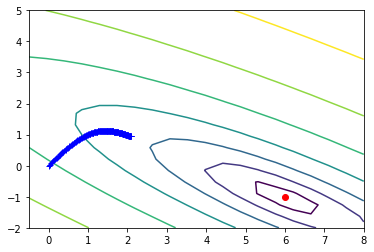

In [12]:
# tracer de l'espace des couts
def plot_parametres( allw, X, y, opti = [], ngrid = 20, extract_bornes=False):
    '''
    Fonction de tracer d'un historique de coefficients
    ATTENTION: ca ne marche qu'en 2D (évidemment)
    Chaque w doit contenir 2 valeurs
    
    Il faut fournir les données (X,y) pour calculer le cout associé 
    à un jeu de paramètres w
    ATTENTION X = forme matricielle des données
    '''
    w_min = [-0.5, -2] # bornes par défaut, uniquement pour notre cas d'usage
    w_max = [8, 5]
    if extract_bornes: # bornes générales
        w_min = np.min(allw,0) # trouver les bornes
        w_max = np.max(allw,0)
    # faire une grille régulière avec tous les couples possibles entre le min et le max
    w1range = np.linspace(w_min[0], w_max[0], ngrid)
    w2range = np.linspace(w_min[1], w_max[1], ngrid)
    w1,w2 = np.meshgrid(w1range,w2range)
    #
    # calcul de tous les couts associés à tous les couples de paramètres
    cost = np.array([[np.log(((X @ np.array([w1i,w2j])-y)**2).sum()) for w1i in w1range] for w2j in w2range])
    #
    plt.figure()
    plt.contour(w1, w2, cost)
    if len(opti) > 0:
        plt.scatter(wstar[0], wstar[1],c='r')
    plt.plot(allw[:,0],allw[:,1],'b+-' ,lw=2 )
    return
    
plot_parametres( allw, Xe, y_train, opti=wstar)
plt.show()
# plt.savefig('fig/grad_descente.png')

Vous devez obtenir un image de la forme :
![Descente de gradient](fig/grad_descente.png)

Tester différents jeux de paramètres pour mettre en évidence les phénomènes suivants:
 - Divergence du gradient
 - Convergence incomplète (trop lente ou pas assez d'itération)
 - Convergence idéale: pas de gradient suffisamment grand et nombre d'itérations bien choisi

# Passage sur des données réelles

Après avoir étudié trois manières de faire face au problème de la régression, nous proposons d'étudier un cas réel: la prédiction de la consommation des voitures en fonction de leurs caractéristiques.

Dans le cas présent, nous allons baser la solution sur la résolution analytique du problème des moindres carrés (`np.linalg.solve(A,B)`), qui semble la mieux adaptée au problème qui nous intéresse.

Le jeu de données est issu des datasets UCI, un répertoire parmi les plus connus en machine learning. Les données **sont déjà téléchargées et présentes dans le tme** mais vous voulez plus d'informations:
https://archive.ics.uci.edu/ml/datasets/auto+mpg

![voiture](fig/Large9.jpg)

Après avoir importé les données (fonction fournie), vous construirez une solution optimale et l'évaluerez au sens des moindres carrés en apprentissage et en test.


In [13]:
import pandas as pd
# Chargement des données
data = pd.read_csv('data/auto-mpg.data', delimiter='\s+', header=None) # comme np.loadtxt mais en plus robuste
# remplacement des données manquantes '?' => Nan pour travailler sur des nombres
data.iloc[:,[3]] = data.iloc[:,[3]].replace('?', None)
data.iloc[:,[3]] = data.iloc[:,[3]].astype(float)
# remplacement des valeurs manquantes par la moyenne
data.iloc[:,[3]] = data.iloc[:,[3]].fillna(data.iloc[:,[3]].mean())

print(data.head()) # visualiser ce qu'il y a dans les données

X = np.array(data.values[:,1:-2], dtype=np.float64)
y = np.array(data.values[:,0], dtype=np.float64)


      0  1      2      3       4     5   6  7                          8
0  18.0  8  307.0  130.0  3504.0  12.0  70  1  chevrolet chevelle malibu
1  15.0  8  350.0  165.0  3693.0  11.5  70  1          buick skylark 320
2  18.0  8  318.0  150.0  3436.0  11.0  70  1         plymouth satellite
3  16.0  8  304.0  150.0  3433.0  12.0  70  1              amc rebel sst
4  17.0  8  302.0  140.0  3449.0  10.5  70  1                ford torino


In [14]:
# separartion app/test
def separation_train_test(X, y, pc_train=0.75):
    N = X.shape[0]
    # on génère tous les index possibles
    index = np.arange(N)
    # on les mélange
    np.random.shuffle(index)
    napp = int(len(y)*pc_train) # nb de points pour le train
    X_train, y_train = X[index[:napp]], y[index[:napp]]
    X_test, y_test   = X[index[napp:]], y[index[napp:]]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = separation_train_test(X, y, pc_train=0.75)

In [15]:
# Résolution analytique

# Une fonction pour ajouter une colonne de np.ones dans une matrice X
# donc une version multidimensionnelle des fonctions définies à l'avant
def make_mat_lin_biais_mat(X):
    return np.hstack((X, np.ones(X.shape[0]).reshape(-1, 1)))

Xe = make_mat_lin_biais_mat(X_train)
Xe_t = make_mat_lin_biais_mat(X_test)
w = np.linalg.solve(np.dot(Xe.T, Xe), np.dot(Xe.T, y_train)) # calcul de w
print(w)
yhat   = np.dot(Xe, w) # prédiction de y d'apprentissage
yhat_t = np.dot(Xe_t, w) # prédiction de y de tests
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))


[-4.32060373e-01  1.45651012e-02 -2.61739435e-03 -7.25956398e-03
  1.85781625e-01  7.33670332e-01 -1.36914259e+01]
Erreur moyenne au sens des moindres carrés (train): 11.519315032852978
Erreur moyenne au sens des moindres carrés (test): 12.407773674442945


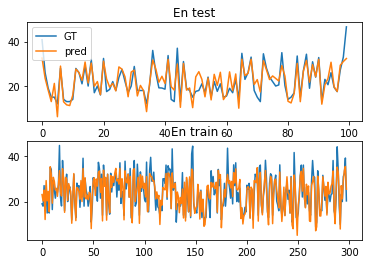

In [16]:
def plot_y(y_train, y_test, yhat, yhat_t):
    # tracé des prédictions:
    plt.figure()
    plt.subplot(211)
    plt.plot(y_test, label="GT")
    plt.plot(yhat_t, label="pred")
    plt.title('En test')
    plt.legend()
    plt.subplot(212)
    plt.plot(y_train, label="GT")
    plt.plot(yhat, label="pred")
    plt.title('En train')
    return

plot_y(y_train, y_test, yhat, yhat_t)
plt.show()

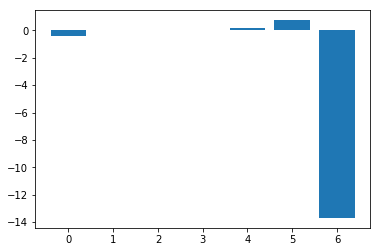

In [17]:
# interprétation des poids
plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()

## Normalisation

Sur le diagramme ci-dessus, on ne voit pas grand chose pour une raison évidente: on ne peut pas comparer ces poids qui comparent des variables dont les ordres de grandeur sont différents.

Nous allons donc assimiler chaque colonne $X_j$ à une variable suivant une loi normale et nous allons revenir à une Normale centrée réduite selon la formule de base:

$$X_j \sim \mathcal N(\mu_j, \sigma_j^2) $$
$$\Rightarrow Z_j = \frac{X_j - \mu_j}{\sigma_j} \sim \mathcal N(0, 1) $$

Tous les $Z_j$ sont comparables et nous seront en mesure de comprendre l'impact de chaque variables sur les résultats.

**ATTENTION:** on ne se basera que sur les données d'apprentissage pour le calcul des $\{\mu_j, \sigma_j\}$.

Une fois la normalisation effectuée, analyser l'impact des différentes variables descriptives sur la valeur à prédire.

[-0.7235403   1.49938437 -0.10067003 -6.18691855  0.51343618  2.74464396
 24.03120805]
Erreur moyenne au sens des moindres carrés (train): 11.519315032852978
Erreur moyenne au sens des moindres carrés (test): 12.407773674442906


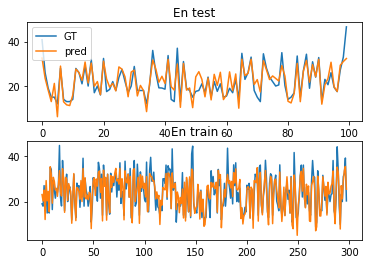

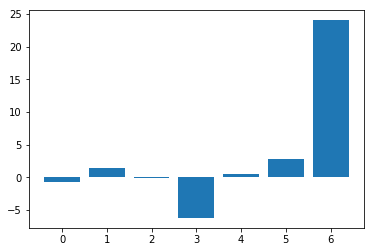

In [18]:
def normalisation(X_train, X_test):
    '''
    Fonction de normalisation des données pour rendre les colonnes comparables
    Chaque variable sera assimilée à une loi normale qu'il faut centrer + réduire.
    ATTENTION: il faut calculer les moyennes et écarts-types sur les données d'apprentissage seulement
    '''
    # On calcule la moyenne et l'écart-type par la colonne à partir des valeurs de X d'apprentissage
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    # On exécute une normalisation de données
    Xn_train = (X_train - mean) / std
    Xn_test = (X_test - mean) / std
    # Ajout d'un biais
    Xn_train = np.hstack((Xn_train, np.ones((Xn_train.shape[0], 1))))
    Xn_test   = np.hstack((Xn_test, np.ones((Xn_test.shape[0], 1))))
    return Xn_train, Xn_test

Xn_train, Xn_test = normalisation(X_train, X_test)
w = np.linalg.solve(np.dot(Xn_train.T, Xn_train), np.dot(Xn_train.T, y_train)) # calcul de w
print(w)

yhat   =  np.dot(Xn_train, w) # On prédit y d'apprentissage
yhat_t =  np.dot(Xn_test, w) # On prédit y de tests
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t, y_test))
plot_y(y_train, y_test, yhat, yhat_t)

plt.figure()
plt.bar(np.arange(len(w)), w)
plt.show()
# On voit que la normalisation a changé les poids de telle façon qu'ils sont plus comparable à l'instant
# Par contre, on voit aussi qu'une normalisation ne change pas les erreurs des prédictions

In [19]:
X_train.shape

(298, 6)

# Questions d'ouverture

## Sélection de caractéristiques

Quels sont les résultats obtenus en éliminant toutes les variables servent moins?

## Feature engineering

En étudiant la signification des variables du problèmes, on trouve:

1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 

D'après la question précédente, le poids, l'année du modèle et le biais sont des facteurs important pour le calcul de la consommation... Jusqu'ici, nous n'avons pas pris en compte l'origine qui était difficile à coder.

### Encodage de l'origine

La variable origine est accessible de la manière suivante:

```
  origine = data.values[:,-2]
```
Il faut le faire au début du traitement pour bien conserver la séparation en l'apprentissage et le test.

Au moins les deux derniers facteurs discrets pourraient être traités différemment en one-hot encoding:
$$X_j = x \in \{1, \ldots, K\} \Rightarrow [0, 0, 1, 0] \in \{0, 1\}^K$$

La valeur $x$ donne l'index de la colonne non nulle.

### Encodage de l'année

Pour l'année, il est possible de procéder de la même manière, mais il préférable de découper les années en 10 catégories puis d'encoder pour limiter le nombre de dimensions.

Caractéristiques importantes : ['displacement' 'weight' 'model year' 'biais']
[-0.09783137 -5.52777519  2.83618357 23.36577181]
Erreur moyenne au sens des moindres carrés (train): 11.137589881809136
Erreur moyenne au sens des moindres carrés (test): 13.455886350160148


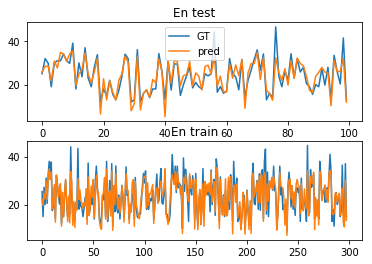

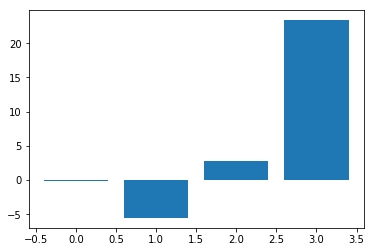

In [20]:
# Sélection de caractéristiques
# On peut proposer ici le test le plus simple : on va dire qu'une caractéristique est important si le poids
# correspondant wi vérifie une condition suivante |wi| >= 1. On note que ce test n'est pas du tout idéal
allf = np.array(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'biais'])
print('Caractéristiques importantes : {0}'.format(allf[np.abs(w) >= 1]))
# On teste qu'est-ce qu'on va obtenir si on reste juste des caractéristiques importantes
Xp = np.array(data.values[:,np.arange(data.shape[1]-3)[np.abs(w[:-1:]) >= 1] + 1], dtype=np.float64)
yp = np.array(data.values[:,0], dtype=np.float64)
Xp_train, yp_train, Xp_test, yp_test = separation_train_test(Xp, yp, pc_train=0.75)
Xpn_train, Xpn_test = normalisation(Xp_train, Xp_test)
wp = np.linalg.solve(np.dot(Xpn_train.T, Xpn_train), np.dot(Xpn_train.T, yp_train))
print(wp)

yphat   =  np.dot(Xpn_train, wp)
yphat_t =  np.dot(Xpn_test, wp)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yphat, yp_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yphat_t, yp_test))
plot_y(yp_train, yp_test, yphat, yphat_t)

plt.figure()
plt.bar(np.arange(len(wp)), wp)
plt.show()
# Bien qu'on aie supprimé du modèle des paramètres qui valent moins on peut observer les erreurs des prédictions
# proches de celles à l'avant
# On peut conclure donc qu'un modèle sans ces paramètres supprimés est plus intéressant
# car on n'a pas perdu l'exactitude des calcules alors qu'on a diminué un nombre de dimensions donc on a une
# possibilité de stocker et traiter beaucoup moins de données

# Question d'ouverture sur le gradient

## La normalisation a-t-elle un impact sur le gradient?

La normalisation des données peut au moins nous aider à régler plus facilement le pas (qui sera toujours du même ordre de grandeur... Mais cela a-t-il un impact sur la manière dont nous nous rapprochons de la solution optimale?

## Gradient stochastique

Dans la plupart des algorithmes modernes d'optimisation liés aux réseaux de neurones, le gradient est calculé de manière stochastique, sur un exemple à la fois:

- $w_0 \leftarrow init$ par exemple : 0
- boucle
     - tirage d'une donnée $i$: $(x_i,y_i)$
     - $w_{t+1} \leftarrow w_{t} - \epsilon \nabla_w C_i(w)$


Etudier le fonctionnement de cet algorithme sur les exemples jouets précédents.

## Amélioration du gradient

Le blog de S. Ruder explique particulièrement bien les améliorations possibles sur les descentes de gradient.

https://ruder.io/optimizing-gradient-descent/

Comparer une descente de gradient stochastique avec et sans moment sur les données jouets des premières questions.

[-0.55006771 -0.40193065 -1.06149568 -3.91875461 -0.1302851   2.57402124
 24.03109757]
Erreur moyenne au sens des moindres carrés (train): 11.977486916959514
Erreur moyenne au sens des moindres carrés (test): 12.357823705452915


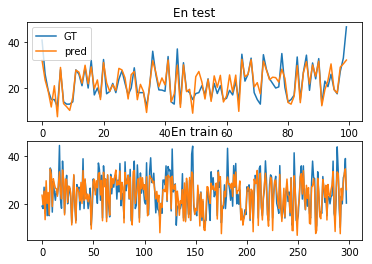

In [21]:
# Premièrement, testons comment marche-t-elle la méthode réalisée ci-dessus pour la descente du gradient simple
w_grad_simple, _ = descente_grad_mc(Xn_train, y_train, eps=1e-4, nIterations=200)
print(w_grad_simple)

yhat_grad_simple   =  np.dot(Xn_train, w_grad_simple)
yhat_t_grad_simple =  np.dot(Xn_test, w_grad_simple)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_grad_simple , y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t_grad_simple, y_test))
plot_y(y_train, y_test, yhat_grad_simple, yhat_t_grad_simple)

plt.show()

[-0.59423409 -0.49101743 -1.10732541 -3.77020058 -0.1621599   2.56552674
 24.03246668]
Erreur moyenne au sens des moindres carrés (train): 12.036000914538052
Erreur moyenne au sens des moindres carrés (test): 12.415295470224015


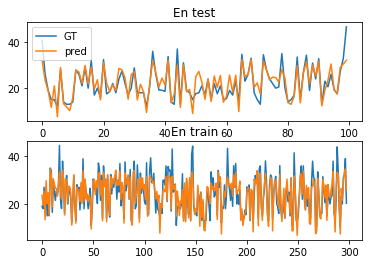

In [22]:
# Pour tester la descente du gradient stochastique réalisons d'abord une fonction correspondante
def stochastic_gradient_descent_mc(X, y, eps=1e-4, nIterations=100, w0=None):
    w = w0.copy() if w0 is not None else np.zeros(X.shape[1])
    allw = [w.copy()]
    for _ in range(nIterations):
        line_index = np.arange(X.shape[0])
        np.random.shuffle(line_index)
        for i in line_index:
            grad = 2.0 * (np.dot(X[i], w) - y[i]) * X[i]
            w = w - eps * grad
        allw.append(w)
    return w, np.array(allw)

# Tests de la descente du gradient stochastique
w_sgd, _ = stochastic_gradient_descent_mc(Xn_train, y_train, eps=1e-4, nIterations=180)
print(w_sgd)

yhat_sgd = np.dot(Xn_train, w_sgd)
yhat_t_sgd = np.dot(Xn_test, w_sgd)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_sgd, y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t_sgd, y_test))
plot_y(y_train, y_test, yhat_sgd, yhat_t_sgd)

plt.show()
# En faisant varier le paramètre nIterations on voit bien que si eps=1e-4 la descente stochastique n'est pas meilleure
# que celle simple
# Par contre, celle stochastique fonctionne bien si on augmente eps vers, par exemple 1e-3 (ou même encore vers la
# valeur plus grand), tandis que la descente simple n'est pas capable de trouver une solution avec la valeur
# d'eps tellement grand

[-0.60108426 -0.43361062 -1.09393555 -3.94610547 -0.13347648  2.61363626
 24.03049464]
Erreur moyenne au sens des moindres carrés (train): 12.004597284263289
Erreur moyenne au sens des moindres carrés (test): 12.432051637388195


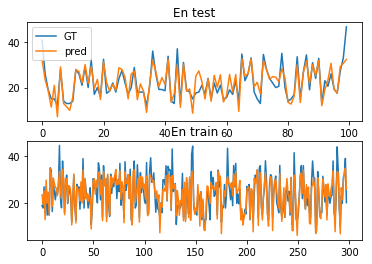

In [23]:
# Pour comparer SGD sans et avec moment on va d'abord implémenter une méthode pour le dernier
def stochastic_gradient_descent_with_momentum_mc(X, y, eps=1e-4, nIterations=100, w0=None, momentum=0.9):
    w = w0.copy() if w0 is not None else np.zeros(X.shape[1])
    allw = [w.copy()]
    aux_vector = np.zeros_like(w)
    for _ in range(nIterations):
        line_index = np.arange(X.shape[0])
        np.random.shuffle(line_index)
        for i in line_index:
            grad = 2.0 * (np.dot(X[i], w) - y[i]) * X[i]
            aux_vector = momentum * aux_vector + eps * grad
            w = w - aux_vector
        allw.append(w)
    return w, np.array(allw)

# Tests de la descente du gradient stochastique avec moment
w_sgd_m, _ = stochastic_gradient_descent_with_momentum_mc(Xn_train, y_train, eps=1e-4, nIterations=20)
print(w_sgd_m)

yhat_sgd_m   =  np.dot(Xn_train, w_sgd_m)
yhat_t_sgd_m =  np.dot(Xn_test, w_sgd_m)
print('Erreur moyenne au sens des moindres carrés (train):', erreur_mc(yhat_sgd_m , y_train))
print('Erreur moyenne au sens des moindres carrés (test):', erreur_mc(yhat_t_sgd_m, y_test))
plot_y(y_train, y_test, yhat_sgd_m, yhat_t_sgd_m)

plt.show()
# C'est claire de résultats obtenus que SGD avec moment a une convergence beaucoup plus rapide (au moins avec 
# " learning rate " = 1e-4); en fait, cet algorithme permet d'obtenir le résultat qui est proche du celui exact
# avec seulement 20 itérations tandis qu'il faut au moins 180 pour SGD sans moment pour atteindre une solution pareille